In [1]:
import os
import sys
import glob

import tensorflow as tf
import numpy as np
import pandas as pd
import keras
from keras.backend.tensorflow_backend import set_session

import matplotlib.pyplot as plt

import nibabel as nib

Using TensorFlow backend.


In [3]:
def load_nii(path):
    nii = nib.load(path)
    vol = nii.get_data().astype(np.float32)
    return np.squeeze(vol)

In [4]:
run_dirs = glob.glob('../runs/*/predict')
run_dirs = sorted(run_dirs)

print('found {} runs'.format(len(run_dirs)), '\n')

for i, run in enumerate(run_dirs):
    print(i, run, '\n')

found 3 runs 

0 ../runs/gan_20190521_0117_gpu=6_bs=16_cl=8_lr=0.0001_b1=0.0_b2=0.9_ep=1e-07_pl=25_lk=0.2_bn=False_vr=1.0_is=5_cs=5_rf=10_rs=5_sw=True_reg=False_clf=False_glw=[1.0_200.0_10.0_10.0_0.0]_clw=[1_1_10]/predict 

1 ../runs/gan_20190522_0000_gpu=6_bs=16_cl=8_lr=0.0001_b1=0.0_b2=0.9_ep=1e-07_pl=25_lk=0.2_bn=True_vr=1.0_is=5_cs=5_rf=10_rs=5_sw=True_reg=False_clf=False_glw=[1.0_200.0_10.0_10.0_0.0]_clw=[1_1_10]/predict 

2 ../runs/gan_20190523_1030_gpu=6_bs=8_cl=8_lr=0.0001_b1=0.0_b2=0.9_ep=1e-07_pl=25_lk=0.2_bn=False_vr=1.0_is=7_cs=5_rf=10_rs=5_sw=weight2_reg=False_clf=False_glw=[1.0_200.0_10.0_0.0_0.0]_clw=[1_1_10]/predict 



In [5]:
# set run dir
run_dir = run_dirs[2]

pre_dirs = glob.glob(os.path.join(glob.escape(run_dir), '*', '*'))
pre_dirs = sorted(pre_dirs)

print('found {} pre_dirs'.format(len(pre_dirs)))

for i, pre_dir in enumerate(pre_dirs):
    #print(i, os.path.basename(pre_dir))
    print(i, pre_dir.split('/')[-2] + '/' + pre_dir.split('/')[-1])

found 1 pre_dirs
0 split_test/gen_050_04


In [6]:
# generator config, run_dir, etc...
pre_dir = pre_dirs[0]

csv_path = os.path.join(pre_dir, 'meta.csv')
csv = pd.read_csv(csv_path)

print('found meta.csv: {}'.format(csv.shape))

found meta.csv: (271, 42)


In [7]:
# classifier
clf_dir = '../../dx/runs/clf_20190516_2031_gpu=4_bs=32_lr=0.0001_b1=0.9_b2=0.999_ep=0.01_bn=True_mp=True_lk=0.0_ls=[16_2_32_1_32_2_64_1_64_2_128_1_128_2_256_1_256_1]_tag=split5_s2s4_s1s3/'

model_name = 'clf_0100'
model_file = os.path.join(clf_dir, model_name+'.h5')

if os.path.isfile(model_file):
    print('found model file')
else:
    print('model file not found!')

found model file


In [8]:
# gpu config
gpu_id = 5

if gpu_id is not None:                                                     
    gpu = '/gpu:' + str(gpu_id)                                            
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)                       
    config = tf.ConfigProto()                                              
    config.gpu_options.allow_growth = True                                 
    config.allow_soft_placement = True                                     
    set_session(tf.Session(config=config))                                 
else:                                                                      
    gpu = '/cpu:0'

In [9]:
print('starting predict')

with tf.device(gpu):
    
    # load classifier model
    classifier = keras.models.load_model(model_file)
    
    for i, (_, row) in enumerate(csv.iterrows()):
        
        if i % 10 == 0:
            print('step', i)
        
        xr = load_nii(row['img_path_0'])[None, ..., None]
        yr = load_nii(row['img_path_1'])[None, ..., None]
        yf = load_nii(row['img_path_yf'])[None, ..., None]
        
        batch = np.concatenate([xr, yr, yf], axis=0)
        
        pred = classifier.predict([batch])
        
        csv.loc[csv.img_id_0 == row['img_id_0'], 'pAD_xr'] = pred[0, 1]
        csv.loc[csv.img_id_0 == row['img_id_0'], 'pAD_yr'] = pred[1, 1]
        csv.loc[csv.img_id_0 == row['img_id_0'], 'pAD_yf'] = pred[2, 1]
        
print('finished predict')

csv_out_path = os.path.join(pre_dir, model_name+'.csv')

print('writing csv to {}'.format(csv_out_path))

csv.to_csv(csv_out_path, index=False)

starting predict
step 0
step 10
step 20
step 30
step 40
step 50
step 60
step 70
step 80
step 90
step 100
step 110
step 120
step 130
step 140
step 150
step 160
step 170
step 180
step 190
step 200
step 210
step 220
step 230
step 240
step 250
step 260
step 270
finished predict
writing csv to ../runs/gan_20190523_1030_gpu=6_bs=8_cl=8_lr=0.0001_b1=0.0_b2=0.9_ep=1e-07_pl=25_lk=0.2_bn=False_vr=1.0_is=7_cs=5_rf=10_rs=5_sw=weight2_reg=False_clf=False_glw=[1.0_200.0_10.0_0.0_0.0]_clw=[1_1_10]/predict/split_test/gen_050_04/clf_0100.csv


In [10]:
clf_csvs = glob.glob(os.path.join(glob.escape(pre_dir), '[!meta]*.csv'))
clf_csvs = sorted(clf_csvs)

for i, clf_csv in enumerate(clf_csvs):
    print(i, os.path.basename(clf_csv))

0 clf_0100.csv


In [11]:
csv_path = clf_csvs[0]
csv = pd.read_csv(csv_path)
print(csv.shape)

(271, 45)


(80, 32, 80)


/local/home/martipa/miniconda3/envs/repro_martipa/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


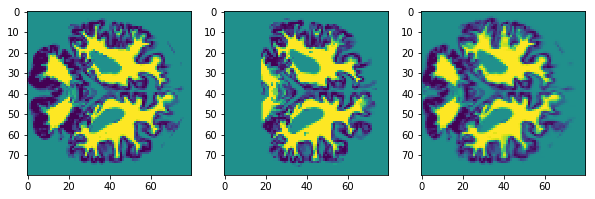

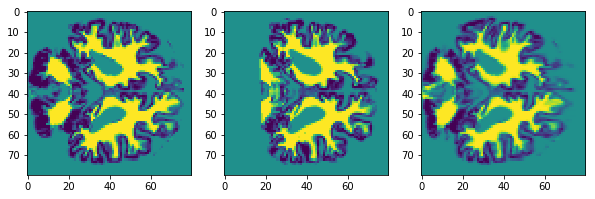

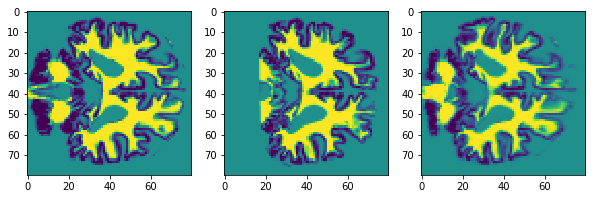

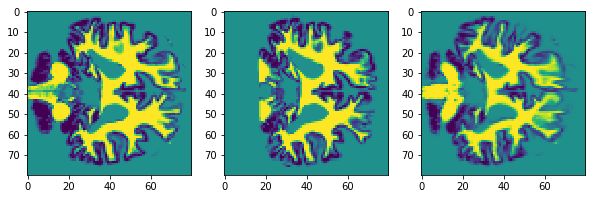

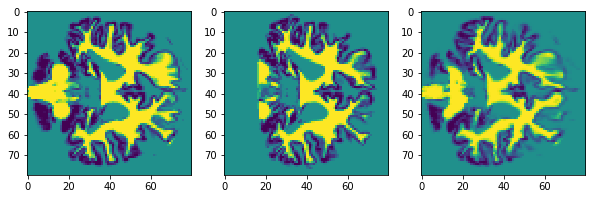

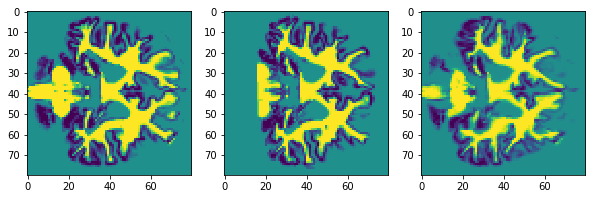

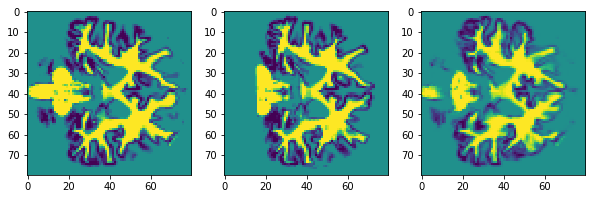

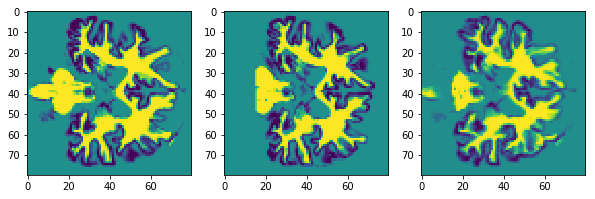

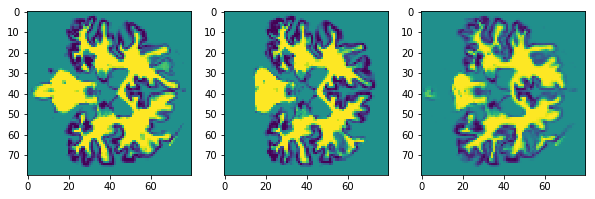

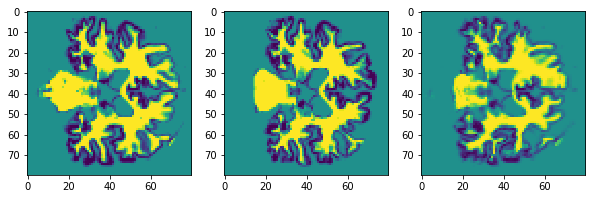

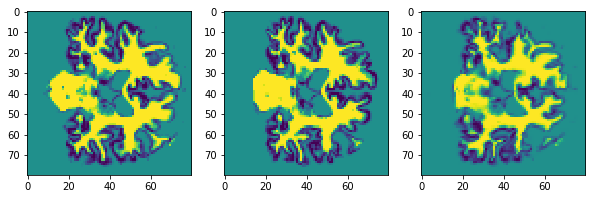

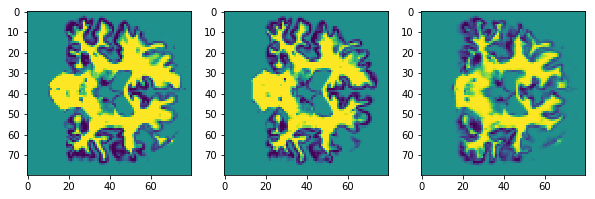

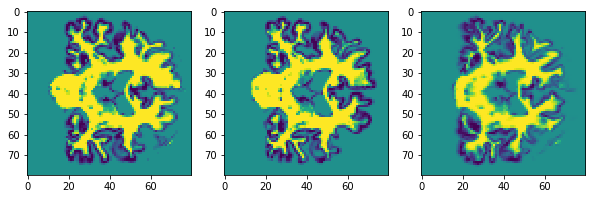

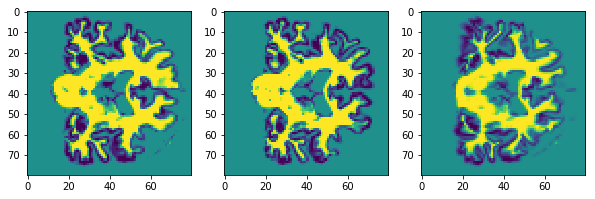

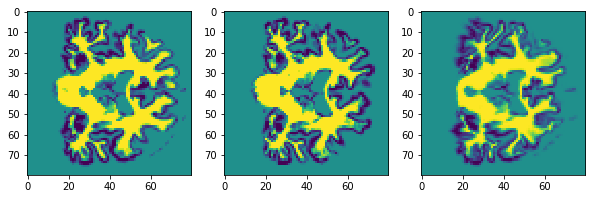

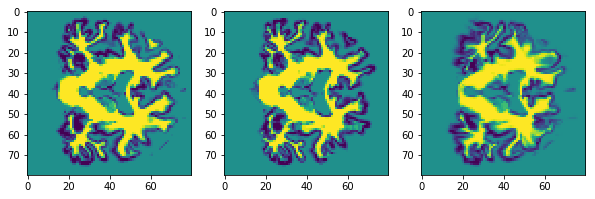

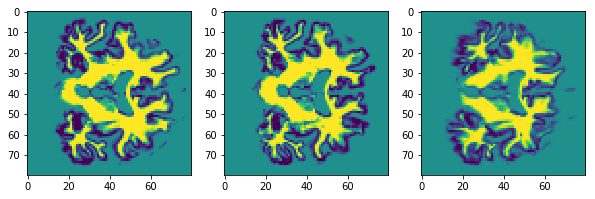

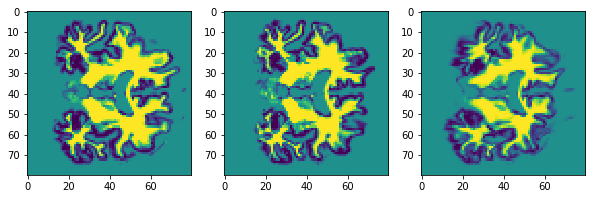

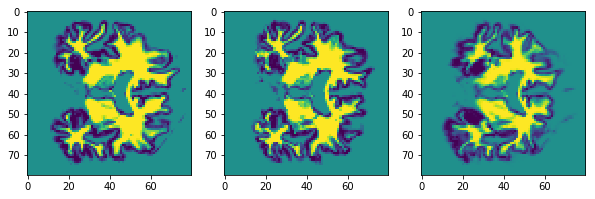

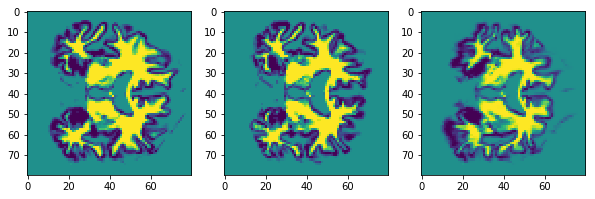

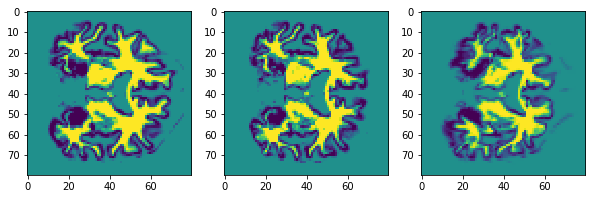

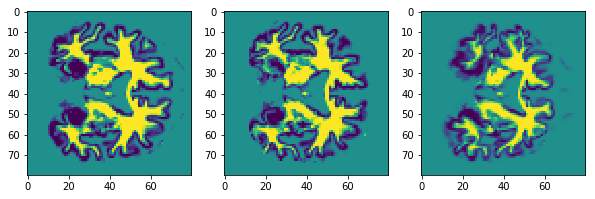

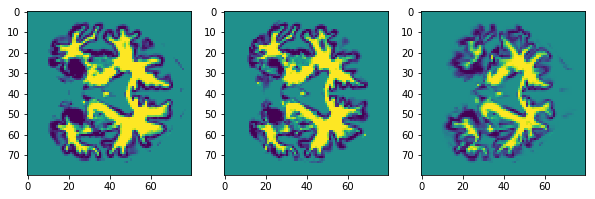

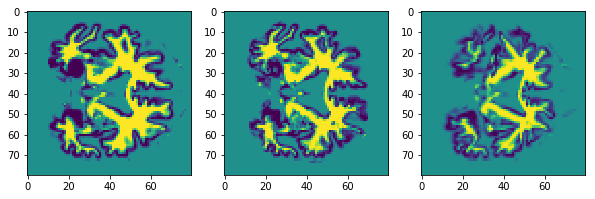

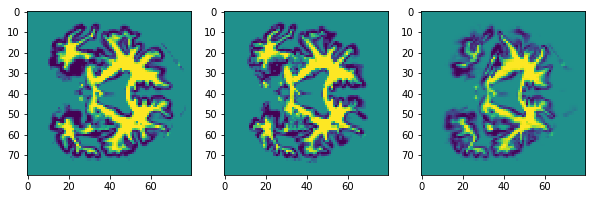

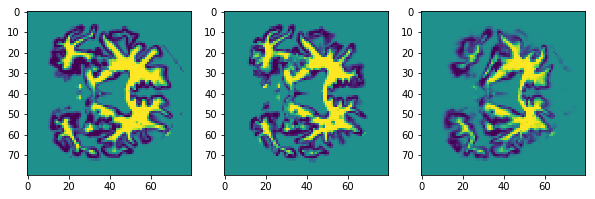

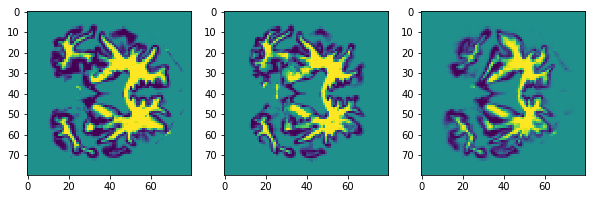

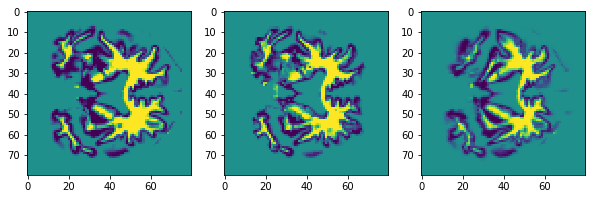

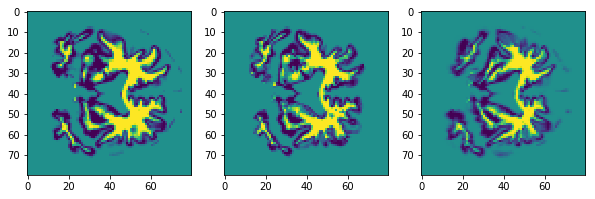

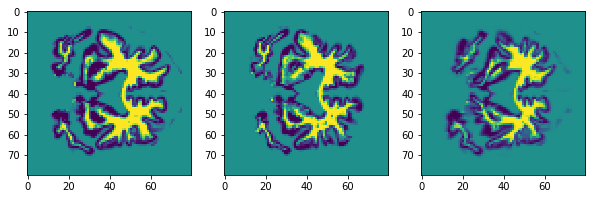

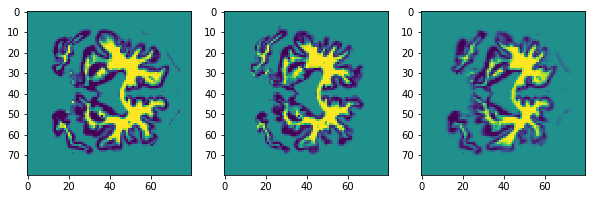

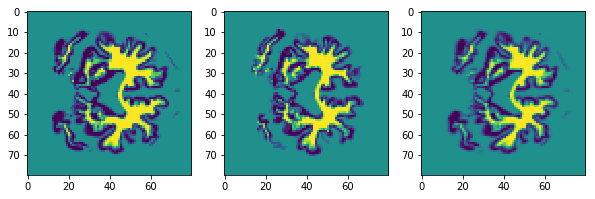

In [23]:
index = 9

vol_0 = load_nii(csv.loc[index].img_path_0)
vol_1 = load_nii(csv.loc[index].img_path_1)
vol_f = load_nii(csv.loc[index].img_path_yf)

print(vol_0.shape)

for i in range(vol_0.shape[1]):
    plt.figure(figsize=(10, 30))
    plt.subplot(1, 3, 1)
    plt.imshow(vol_0[:, i, :])
    plt.subplot(1, 3, 2)
    plt.imshow(vol_1[:, i, :])
    plt.subplot(1, 3, 3)
    plt.imshow(vol_f[:, i, :])

In [12]:
scsv = csv[csv.pat_dx_1 == 2]
print('s: xr -> yr:', (scsv.pAD_yr - scsv.pAD_xr).mean())
print('s: xr -> yf:', (scsv.pAD_yf - scsv.pAD_xr).mean())

pcsv = csv[csv.pat_dx_1 == 3]
print('p: xr -> yr:', (pcsv.pAD_yr - pcsv.pAD_xr).mean())
print('p: xr -> yf:', (pcsv.pAD_yf - pcsv.pAD_xr).mean())

s: xr -> yr: 0.15111474264289695
s: xr -> yf: 0.3134073033959502
p: xr -> yr: 0.3230244204696275
p: xr -> yf: 0.3140053356166428


In [13]:
print(csv[['pAD_xr', 'pAD_yr', 'pAD_yf', 'pat_dx_1']].mean())
csv[['pAD_xr', 'pAD_yr', 'pAD_yf', 'pat_dx_1', 'img_id_0']].head(10)

pAD_xr      0.286097
pAD_yr      0.499379
pAD_yf      0.599721
pat_dx_1    2.361624
dtype: float64


,pAD_xr,pAD_yr,pAD_yf,pat_dx_1,img_id_0
0,0.000316,0.001056,0.608457,2.0,AIBL_137594
1,0.062096,0.906215,0.912071,2.0,AIBL_137615
2,0.806953,0.639290,0.859083,2.0,AIBL_136618
3,0.003908,0.787367,0.276695,2.0,AIBL_138695
4,0.000107,0.000431,0.016013,2.0,AIBL_135979
5,0.525192,0.966170,0.879789,3.0,ADNI_425706
6,0.065960,0.412181,0.849944,3.0,ADNI_377217
7,0.036116,0.481100,0.994007,3.0,ADNI_346498
8,0.996397,0.990513,0.950639,3.0,ADNI_371764
9,0.000295,0.000466,0.186123,2.0,ADNI_412258


In [14]:
def get_metric(csv_in, col, t, metric):

    true_pos = ((csv_in[col] > t) & (csv_in.pat_dx_1 == 3)).sum()
    true_neg = ((csv_in[col] <= t) & (csv_in.pat_dx_1 == 2)).sum()
    false_pos = ((csv_in[col] > t) & (csv_in.pat_dx_1 == 2)).sum()
    false_neg = ((csv_in[col] <= t) & (csv_in.pat_dx_1 == 3)).sum()
    
    true = true_pos + true_neg
    false = false_pos + false_neg

    if metric == 'f1':
        prec = true_pos / (true_pos + false_pos)
        reca = true_pos / (true_pos + false_neg)

        f1_score = 2 * (prec * reca) / (prec + reca)
        m = f1_score
        
    elif metric == 'acc':
        acc_p = true_pos / (true_pos + false_neg)
        acc_s = true_neg / (true_neg + false_pos)

        balanced_acc = (acc_p + acc_s) / 2
        m = balanced_acc
    
    return (round(m, 3), true, false)

In [15]:
def get_best_threshold(csv_in, col, metric):
    l = []
    
    for t in np.arange(0, 1, 0.01):
        m = get_metric(csv_in, col, t, metric)
        l.append((*m, t))
        
    return (max(l)[3])

In [16]:
def get_split_metric(csv_in, col, cv_split, metric):
    
    csv_split = csv_in[csv_in.cv_split == cv_split]
    csv_other = csv_in[csv_in.cv_split != cv_split]
    
    t = get_best_threshold(csv_other, col, metric)
    
    m = get_metric(csv_split, col, t, metric)
    print('split {}: {}, t={}'.format(cv_split, m, t))
    
    return m

In [17]:
def get_cv_metric(csv_in, col, metric):
    l = [get_split_metric(csv_in, col, s, metric)[0] for s in range(5)]
    return np.array(l).mean()

In [18]:
# create 5 folds with equal number of pMCI/sMCI samples each
csv = csv.sample(frac=1).reset_index(drop=True)

pMCI = csv[csv.pat_dx_1 == 3].img_id_0.values
sMCI = csv[csv.pat_dx_1 == 2].img_id_0.values

p_bins = np.linspace(0, len(pMCI), 6).astype(int)[1:-1]
s_bins = np.linspace(0, len(sMCI), 6).astype(int)[1:-1]

p_splits = np.split(pMCI, p_bins)
s_splits = np.split(sMCI, s_bins)

In [19]:
# write folds to csv
for i, (p_split, s_split) in enumerate(zip(p_splits, s_splits)):
    csv.loc[csv.img_id_0.isin(p_split), 'cv_split'] = i
    csv.loc[csv.img_id_0.isin(s_split), 'cv_split'] = i

In [20]:
get_cv_metric(csv, 'pAD_xr', 'f1')

split 0: (0.583, 33, 20), t=0.11
split 1: (0.634, 40, 15), t=0.12
split 2: (0.615, 38, 15), t=0.12
split 3: (0.549, 32, 23), t=0.11
split 4: (0.4, 31, 24), t=0.14


0.5562

In [21]:
get_cv_metric(csv, 'pAD_yr', 'f1')

split 0: (0.55, 35, 18), t=0.65
split 1: (0.652, 39, 16), t=0.31
split 2: (0.739, 41, 12), t=0.31
split 3: (0.615, 35, 20), t=0.59
split 4: (0.605, 38, 17), t=0.73


0.6322

In [22]:
get_cv_metric(csv, 'pAD_yf', 'f1')

split 0: (0.517, 25, 28), t=0.26
split 1: (0.54, 26, 29), t=0.08
split 2: (0.6, 29, 24), t=0.08
split 3: (0.557, 28, 27), t=0.25
split 4: (0.471, 28, 27), t=0.44


0.537

In [23]:
get_cv_metric(csv, 'pAD_xr', 'acc')

split 0: (0.648, 33, 20), t=0.11
split 1: (0.686, 39, 16), t=0.19
split 2: (0.687, 38, 15), t=0.19
split 3: (0.607, 32, 23), t=0.11
split 4: (0.529, 31, 24), t=0.14


0.6314

In [24]:
get_cv_metric(csv, 'pAD_yr', 'acc')

split 0: (0.642, 35, 18), t=0.65
split 1: (0.75, 42, 13), t=0.73
split 2: (0.818, 43, 10), t=0.73
split 3: (0.671, 35, 20), t=0.59
split 4: (0.682, 38, 17), t=0.73


0.7126

In [25]:
get_cv_metric(csv, 'pAD_yf', 'acc')

split 0: (0.598, 32, 21), t=0.85
split 1: (0.639, 35, 20), t=0.84
split 2: (0.593, 34, 19), t=0.9400000000000001
split 3: (0.611, 33, 22), t=0.84
split 4: (0.604, 34, 21), t=0.84


0.609